In [255]:
import osmnx as ox
import os
import geopandas as gpd
import pandas as pd
import numpy as np
import networkx as nx
from shapely.geometry import Point, Polygon, MultiPoint, LineString, MultiLineString
from tqdm import tqdm
import shapely
from shapely import geometry, ops
from shapely.ops import linemerge
import momepy

import matplotlib.pyplot as plt
import math

import powerlaw

In [580]:
def get_slope(line):
    l = len(line.xy[0])-1
    x1, y1, x2, y2 = line.xy[0][0], line.xy[1][0], line.xy[0][l], line.xy[1][l]
    if x2 == x1: # straight vertical line
        return np.inf
    return (y2 - y1) / (x2 - x1)

    
def delta_angle(line1, line2): # angle between two lines
    slope1 = get_slope(line1)
    slope2 = get_slope(line2)

    if slope1 == np.inf and slope2 == np.inf:
        return 0
    
    elif slope1 == np.inf:
        return 90-math.degrees(abs(math.atan(slope2)))

    elif slope2 == np.inf:
        return 90-math.degrees(abs(math.atan(slope1)))
    
    elif slope1 * slope2 == -1:
        return 90

    else:
        angle_degrees = math.degrees(math.atan(abs((slope2 - slope1) / (1 + slope1 * slope2))))

        return angle_degrees


def new_angles(G,touch_buffer):
    nodes = G.nodes(data=True)
    for edges in list(G.edges()):
        u, v = edges
        a =  nodes[u]['geometry']
        b =  nodes[v]['geometry']
        touch_point = a.intersection(b)
        
        # if the touching point is not single point. Eg. Parallel lines
        if type(touch_point)!=Point: 
            angle=delta_angle(a,b)
        else: 
            # TODO: include inf buffer zone
            touch_point_b=touch_point.buffer(touch_buffer)
            cut_a = a.difference(a.difference(touch_point_b)) 
            cut_b = b.difference(b.difference(touch_point_b))
            cut_b = check_string(cut_b,touch_point)
            cut_a = check_string(cut_a,touch_point)
            angle = delta_angle(cut_a, cut_b)
        
        G[u][v]['new_angle'] = angle

    return G

def check_string(l,p):
    if type(l) == MultiLineString:
        for i in l.geoms:
            if i.touches(p):
                return i
    else: 
        return l


def merged_G_angle(G,tresh,attr):
    H = G.copy() 

    # find components that have a similar angle and merge them
    filtered_H = H.copy()
    edges_to_remove = [(u, v) for u, v, a in H.edges(data=True) if (a[attr] > tresh)]  # or (a[attr] > (180 - tresh))
    filtered_H.remove_edges_from(edges_to_remove)

    # Find connected components (groups of nodes to merge)
    components = [H.subgraph(c).copy() for c in nx.connected_components(filtered_H)]
    lengths = nx.get_node_attributes(G, "mm_len")
    geometries = nx.get_node_attributes(G, "geometry")
    
    mapping = {}
    length_map = {}
    geom_map = {}
    
    for comp in components:
        nodes = list(comp.nodes())
        
        # new node id mean node coordinate
        mean_node = tuple(np.mean(np.array(nodes), axis=0))
        mapping.update({n: mean_node for n in nodes})
        
        # Sum up lengths # optional
        length_map[mean_node] = np.sum([lengths.get(n, 0) for n in nodes])
        
        # Merge geometries (LineStrings → MultiLineString → merged line)
        lines = [geometries[n] for n in nodes if n in geometries]
        if lines:
            merged_geom = linemerge(MultiLineString(lines))
            geom_map[mean_node] = merged_geom
    
    # Relabel (merge) nodes in the original graph
    merged_H = nx.relabel_nodes(H, mapping)
    
    # Assign merged attributes
    nx.set_node_attributes(merged_H, length_map, "mm_len")
    nx.set_node_attributes(merged_H, geom_map, "geometry")
    
    return merged_H, mapping, length_map, geom_map

In [581]:
def combine(elements):
    result_list = []
    for item in elements:
        if isinstance(item, int):
            result_list.append(item)
        elif isinstance(item, list):
            result_list.extend(item)
    return result_list

def clean_chains(G_primal):
    while True:
        nodes_to_remove = []
        
        for node in G_primal.nodes():
            neighbors = list(G_primal.neighbors(node))
            degree = G_primal.degree(node)
            if len(neighbors) == 2 and degree == 2:

                my_id = combine([i[2]['id'] for i in list(G_primal.edges(node, data=True))])
                lines = [i[2]['geometry'] for i in list(G_primal.edges(node, data=True))]

                multi_line = ops.linemerge(geometry.MultiLineString(lines))

                G_primal.add_edge(neighbors[1], neighbors[0], 
                                id=my_id,
                                geometry=multi_line,
                                new_edge=True)

                nodes_to_remove.append(node)
                
        if not nodes_to_remove: # if empty
            break
        G_primal.remove_nodes_from(nodes_to_remove)

    return G_primal

In [371]:
place_name = "Frederiksberg Municipality, Denmark"
G = ox.graph_from_place(place_name, network_type="all")  

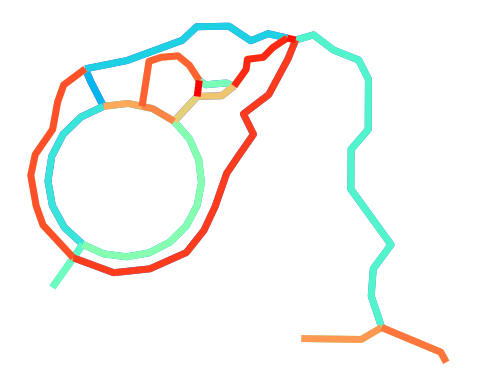

In [546]:
# for s in [52,21,12]:
np.random.seed(52) 
start = np.random.choice(list(G.nodes))

nodes_within_N = nx.single_source_shortest_path_length(G, start, cutoff=4)
subG = G.subgraph(nodes_within_N.keys()).copy()
shape_df = ox.graph_to_gdfs(subG,nodes=False)
shape_df.crs = "epsg:4326"
shape_df = shape_df.to_crs(3857)

fig, ax = plt.subplots()
shape_df.sample(frac=1).plot(cmap='rainbow',ax=ax,linewidth=5)
ax.axis('off')
plt.show()

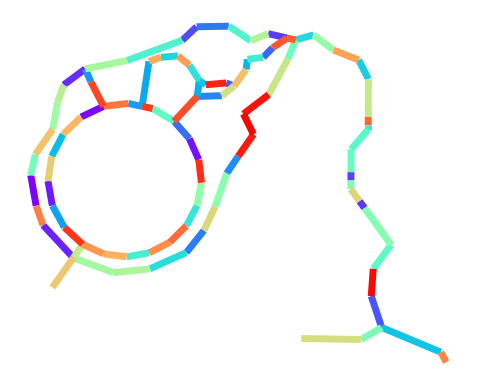

In [547]:
shape_df = shape_df.reset_index().explode('geometry')
u = shape_df.union_all()
i = u.intersection(u)

out = gpd.GeoDataFrame(geometry=gpd.GeoSeries(i, crs=shape_df.crs).explode()).reset_index(drop=True)
shape_exploded_df = out.sjoin(shape_df[['osmid', 'geometry']], how="left", predicate="intersects")
shape_exploded_df = shape_exploded_df.drop_duplicates(subset=['geometry'])

shape_exploded_df = shape_exploded_df.reset_index(drop=True)
shape_exploded_df['id'] = shape_exploded_df.index

fig, ax = plt.subplots()
shape_exploded_df.sample(frac=1).plot(cmap='rainbow',ax=ax,linewidth=5)
ax.axis('off')
plt.show()

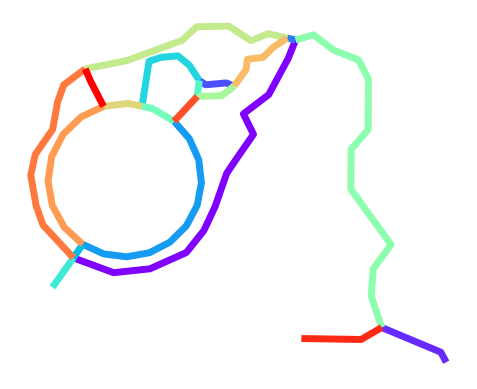

In [548]:
G_primal = momepy.gdf_to_nx(shape_exploded_df, approach="primal")
G_primal = clean_chains(G_primal)
_, lines = momepy.nx_to_gdf(G_primal)

fig, ax = plt.subplots()
lines.sample(frac=1).plot(cmap='rainbow',ax=ax,linewidth=5)
ax.axis('off')
plt.show()

In [579]:
G_dual = momepy.gdf_to_nx(lines , approach='dual', multigraph=False, angles=True)
G_dual = new_angles(G_dual,touch_buffer=5)

H = G_dual.copy()
tresh = 50

df = pd.DataFrame(
    [(u, v, *a.values()) for u, v, a in H.edges(data=True)],
    columns=["u", "v"] + list(next(iter(H.edges(data=True)))[2].keys())
)
df.loc[df['new_angle'] > 30].groupby('u').count()

v  angle  new_angle
u                                                            
(1393846.5129760352, 7493665.176563917)   1      1          1
(1393852.8622801485, 7493609.44233286)    2      2          2
(1393853.811910682, 7493660.979821087)    1      1          1
(1393860.5210611152, 7493620.368708116)   3      3          3
(1393883.2695947213, 7493694.524381108)   1      1          1
(1393901.3441491262, 7493690.569387596)   1      1          1
(1393904.0329856644, 7493711.372465177)   1      1          1
(1393904.6830323092, 7493641.154395447)   1      1          1
(1393915.1121394, 7493692.5009596925)     4      4          4
(1393915.9004268707, 7493725.577268442)   1      1          1
(1393921.4963121973, 7493702.8549721595)  3      3          3
(1393925.6118791811, 7493654.355049725)   1      1          1
(1393930.712532146, 7493705.239506586)    2      2          2
(1393930.8650923711, 7493700.003874835)   1      1          1
(1393951.755371709, 7493717.389557413)    2      2          2
(1393968.74030409, 7493727.93562874)      1      1          1
(1393994.7701169648, 7493576.552535666)   1      1          1
(1394003.6930931187, 7493663.540541306)   2      2          2

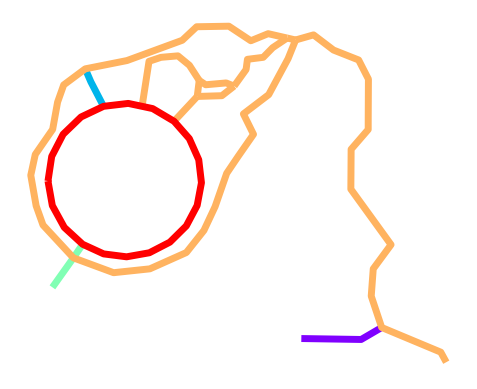

In [567]:
G_dual = momepy.gdf_to_nx(lines , approach='dual', multigraph=False, angles=True)
G_dual=new_angles(G_dual,touch_buffer=5)

angle_thresholds = 50

H, mapping, length_map, geom_map = merged_G_angle(G_dual,tresh=angle_thresholds,attr='new_angle',merge_only_one=False)
df_nodes = pd.DataFrame.from_dict(dict(H.nodes(data=True)), orient='index')
gdf_merged = gpd.GeoDataFrame(df_nodes, geometry='geometry')

fig, ax = plt.subplots()
gdf_merged.sample(frac=1).plot(cmap='rainbow',ax=ax,linewidth=5)
ax.axis('off')
plt.show()

# Examples

In [ ]:
def get_dual_dir_con(subG,t_buffer,a_threshold):
    shape_df = ox.graph_to_gdfs(subG,nodes=False)
    shape_df.crs = "epsg:4326"
    shape_df = shape_df.to_crs(3857)

    shape_df = shape_df.reset_index().explode('geometry')
    u = shape_df.union_all()
    i = u.intersection(u)
    out = gpd.GeoDataFrame(geometry=gpd.GeoSeries(i, crs=shape_df.crs).explode()).reset_index(drop=True)
    shape_exploded_df = out.sjoin(shape_df[['osmid', 'geometry']], how="left", predicate="intersects")
    shape_exploded_df = shape_exploded_df.drop_duplicates(subset=['geometry'])

    shape_exploded_df = shape_exploded_df.reset_index(drop=True)
    shape_exploded_df['id'] = shape_exploded_df.index

    G_primal = momepy.gdf_to_nx(shape_exploded_df, approach="primal")
    G_primal = clean_chains(G_primal)
    _, lines = momepy.nx_to_gdf(G_primal)


    G_dual = momepy.gdf_to_nx(lines , approach='dual', multigraph=False, angles=True)
    G_dual=new_angles(G_dual,touch_buffer=t_buffer)

    angle_thresholds = a_threshold

    H, mapping, length_map, geom_map = merged_G_angle(G_dual,tresh=angle_thresholds,attr='new_angle')
    df_nodes = pd.DataFrame.from_dict(dict(H.nodes(data=True)), orient='index')
    gdf_merged = gpd.GeoDataFrame(df_nodes, geometry='geometry')
    gdf_merged['degree']=np.array([d for n, d in H.degree()])

    return gdf_merged, H

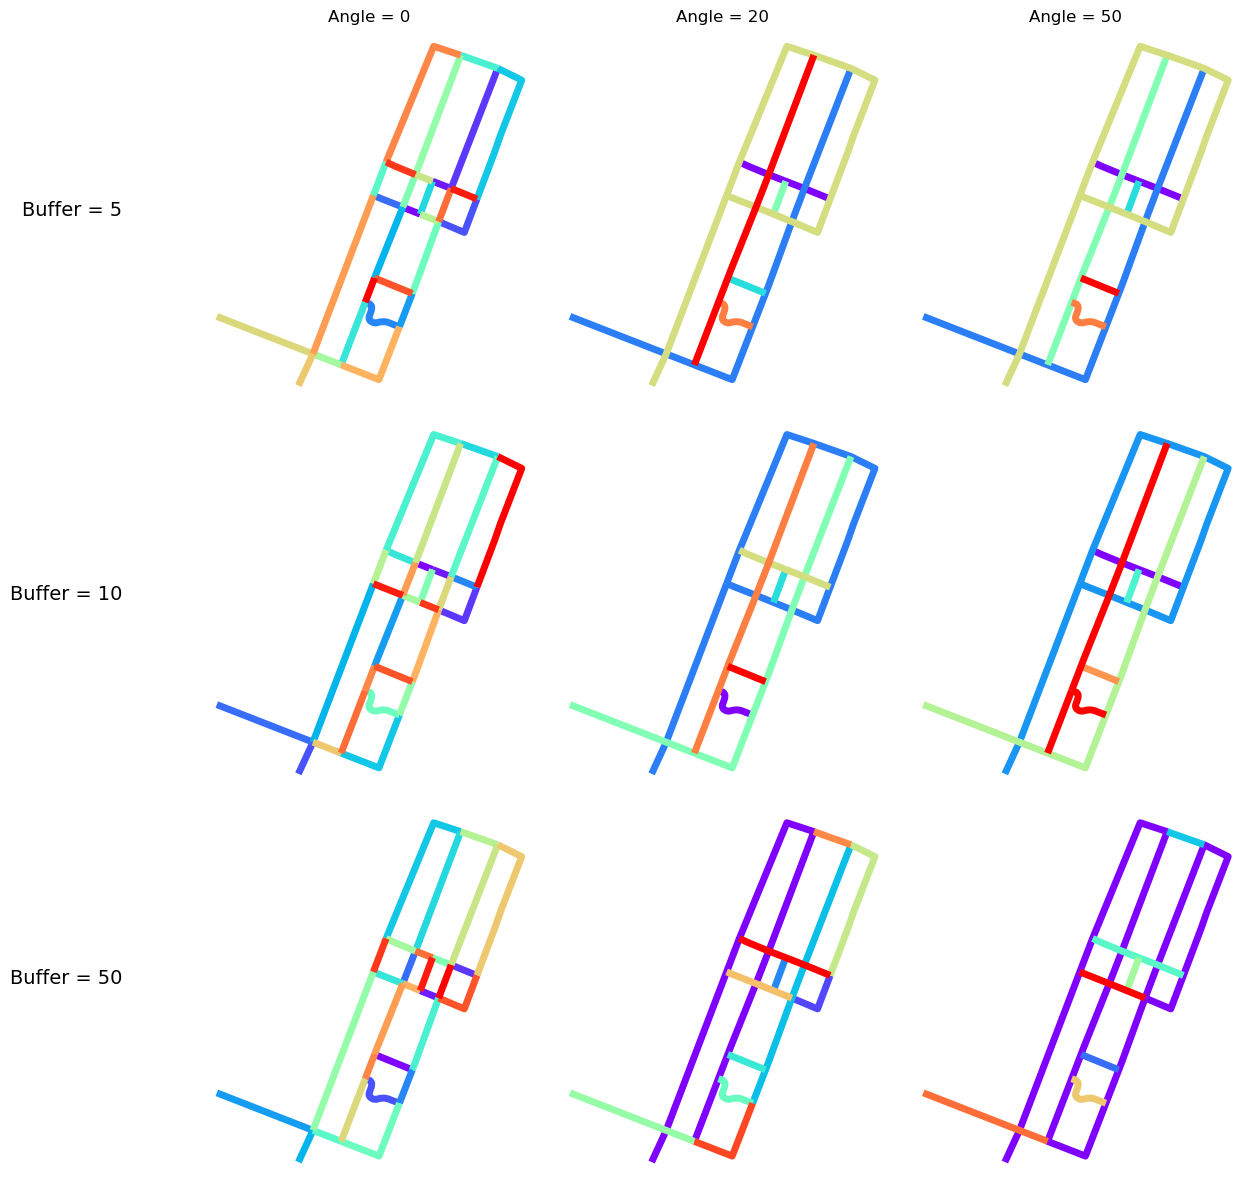

In [483]:
for s in [52,21,12]:
    np.random.seed(s) 
    start = np.random.choice(list(G.nodes))

    fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))

    b_vals = [5, 10, 50]
    a_vals = [0, 20, 50]

    for i, b in enumerate(b_vals):
        for j, a in enumerate(a_vals):
            ax = axs[i][j]

            nodes_within_4 = nx.single_source_shortest_path_length(G, start, cutoff=4)
            subG = G.subgraph(nodes_within_4.keys()).copy()
            gdf_merged, _ = get_dual_dir_con(subG, t_buffer=b, a_threshold=a)
            gdf_merged.sample(frac=1).plot(cmap='rainbow', ax=ax, linewidth=5)
            ax.axis('off')

            # Column titles
            if i == 0:
                ax.set_title(f"Angle = {a}")

    # Big row labels on the left side
    for i, b in enumerate(b_vals):
        fig.text(0.04, 0.82 - i * 0.32, f"Buffer = {b}", va='center', ha='right', fontsize=14)

    plt.tight_layout(rect=[0.08, 0, 1, 1])
    plt.show()

In [ ]:
# fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(25, 15))
# plt.show()

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(25, 15))

b_vals = [5, 10]
a_vals = [10, 20, 30]

for i, b in enumerate(b_vals):
    for j, a in enumerate(a_vals):
        ax = axs[i][j]


        gdf_merged, _ = get_dual_dir_con(G, t_buffer=b, a_threshold=a)
        gdf_merged.plot(column='degree', cmap='Reds', ax=ax, linewidth=.8)
        ax.axis('off')

        # Column titles
        if i == 0:
            ax.set_title(f"Angle = {a}")

# Big row labels on the left side
for i, b in enumerate(b_vals):
    fig.text(0.04, 0.82 - i * 0.32, f"Buffer = {b}", va='center', ha='right', fontsize=14)

plt.tight_layout(rect=[0.08, 0, 1, 1])
plt.show()

# Copenhagen

In [129]:
place_name = "Copenhagen Municipality, Denmark"
G = ox.graph_from_place(place_name, network_type="all")
gdf_merged, H = get_dual_dir_con(G, t_buffer=5, a_threshold=30)

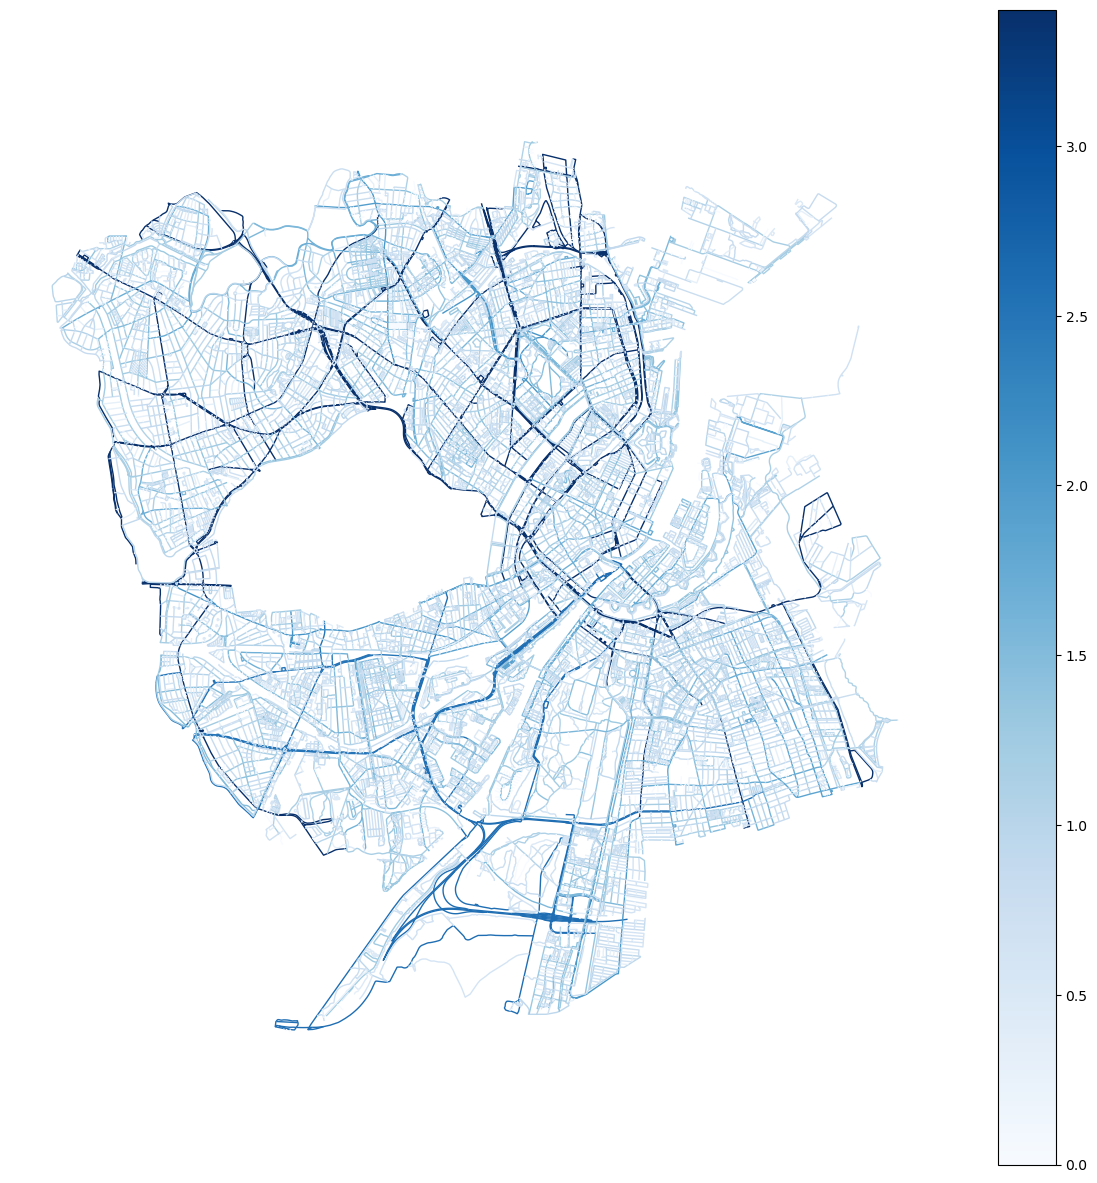

In [ ]:
gdf_merged['degree_log'] = gdf_merged.degree.apply(np.log10)

fig, ax = plt.subplots(figsize=(15,15))
gdf_merged.plot(column='degree_log', cmap='Blues', ax=ax, linewidth=1,legend=True)
ax.axis('off')
plt.show()

In [94]:
def compute_ks(degree,min_range):
    distance = []
    for i_min in min_range:
        fit = powerlaw.Fit(degree,discrete=True,xmin=i_min)
        a = fit.alpha
        xmin = fit.xmin
        x_fit = degree[degree>xmin]
        distance.append(fit.power_law.D)

    return np.array(distance), min_range


degree_obs_val = gdf_merged.degree.values

ps = 6

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5),dpi=150)
axs = axs.ravel()
ax = axs[0]

# Histogram data
y, x = np.histogram(degree_obs_val, bins=np.logspace(0, np.log10(degree_obs_val.max()), len(np.unique(degree_obs_val))), density=True)
x = x[:-1]
x_nn = x[y != 0][:-1]
y_nn = y[y != 0][:-1]

ax.scatter(x_nn, y_nn, alpha=1, zorder=2, color='k')
ax.axvline(ps,label=f'Degree: {ps}',color='red')
ax.legend()

# Log-log scaling and labels
ax.set_ylabel('p(x)')
ax.set_xlabel('Degree')
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_title("Degree Distribution")


ks_dist, xmins = compute_ks(degree_obs_val, range(1,50))


ax2 = axs[1]
ax2.scatter(xmins,1-ks_dist,color='red')
ax2.plot(xmins,1-ks_dist,color='red')
ax2.axvline(ps,color='k',linestyle='dotted',label='Shift: '+str(ps))
ax2.set_xlabel('xmin')
ax2.set_ylabel('1 - Distance')
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.legend()
ax2.set_title('Kolmogorov–Smirnov Distance')

plt.tight_layout()
plt.show()




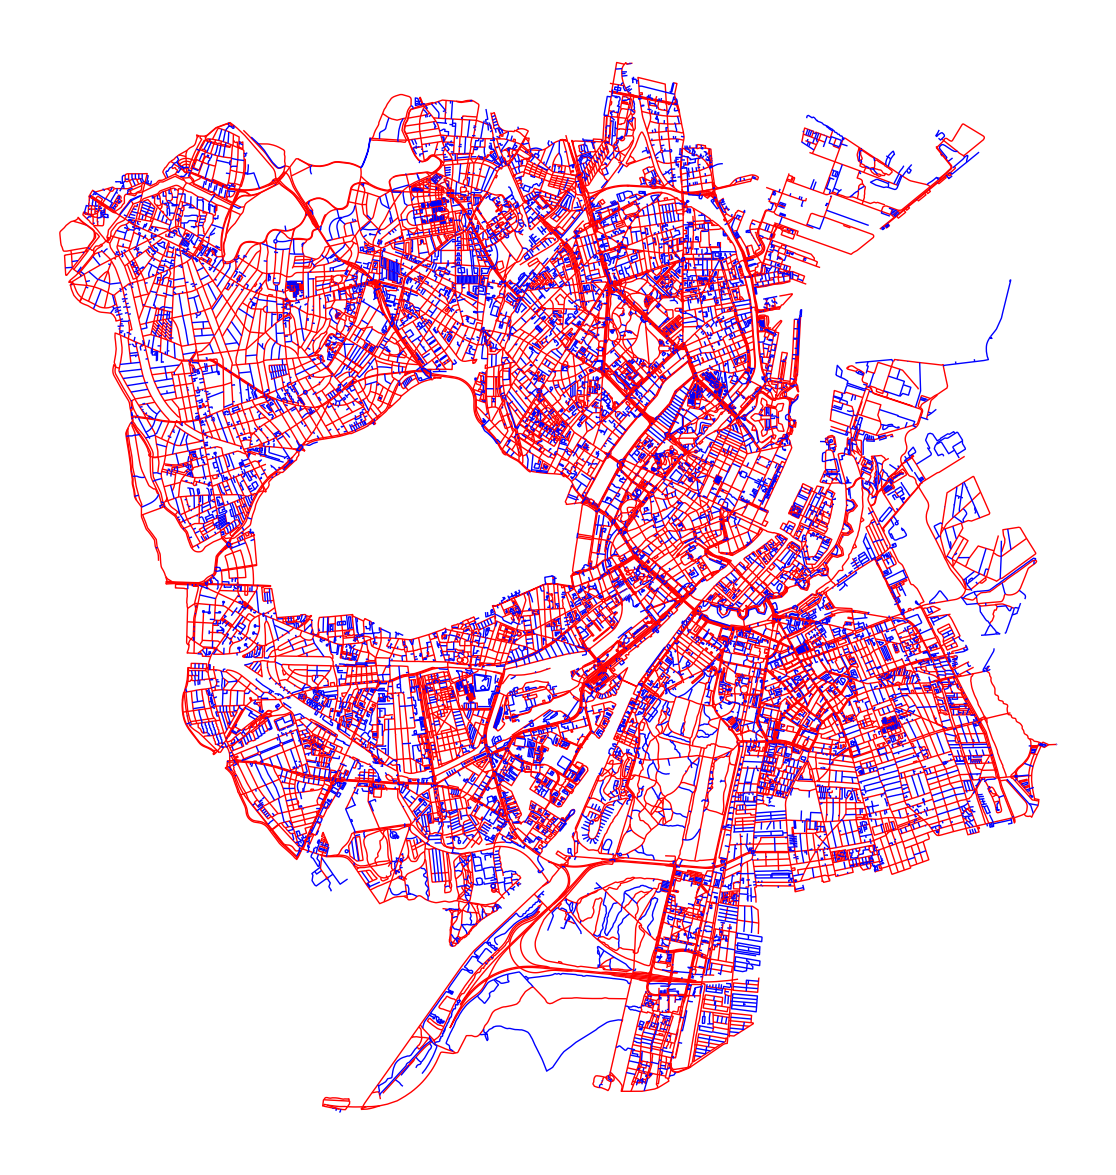

In [105]:
fig, ax = plt.subplots(figsize=(15,15))
# ps  = 6
gdf_merged[gdf_merged.degree>=ps].plot(color='red', ax=ax, linewidth=1)
gdf_merged[gdf_merged.degree<ps].plot(color='blue', ax=ax, linewidth=1)
ax.axis('off')
plt.show()

In [192]:
from sklearn.preprocessing import normalize

In [368]:
# plt.figure()


# A = gdf_merged.sample(1).index[0]
# B = gdf_merged.sample(1).index[0]

# path = nx.shortest_path(H, A, B, weight="weight")
# degree_seq = gdf_merged.loc[path].degree.values

# plt.plot(np.arange(len(degree_seq)), degree_seq, alpha=1)
# plt.show()

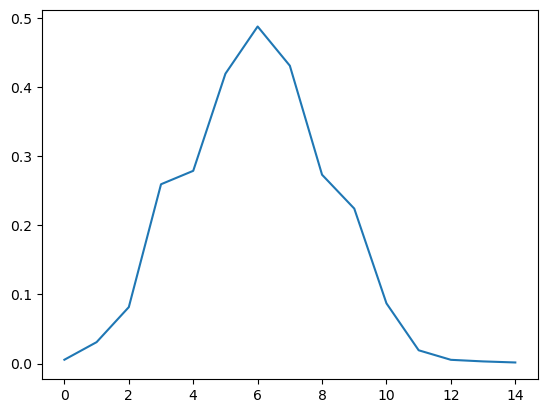

In [ ]:
xs = []
ys = []

for sdfsdf in range(10_000):
    A = gdf_merged.sample(1).index[0]
    B = gdf_merged.sample(1).index[0]

    path = nx.shortest_path(H, A, B)
    degree_seq = gdf_merged.loc[path].degree.values

    x=np.arange(len(degree_seq))/len(degree_seq)
    y=degree_seq/np.max(degree_seq)

    xs.append(x)
    ys.append(y)


xs_arr = np.concatenate(xs)
ys_arr = np.concatenate(ys)

n_bins = 15
bins = np.linspace(0, 1, n_bins + 1)

idx = np.digitize(xs_arr, bins) - 1

bin_means = np.array([ys_arr[idx == i].mean() if np.any(idx == i) else np.nan for i in range(n_bins)])

plt.plot(bin_means)

In [ ]:
for n in H.nodes:
    H.nodes[n]["L"] = gdf_merged.loc[n].geometry.length

for u, v in H.edges:
    H.edges[u, v]["L"] = (H.nodes[u]["L"] + H.nodes[v]["L"]) / 2

In [330]:
import numpy as np
import networkx as nx
from multiprocessing import Pool

In [362]:
def sample_path(norm = True):
    A = gdf_merged.sample(1).index[0]
    B = gdf_merged.sample(1).index[0]

    # Weighted path
    path_w = nx.shortest_path(H, A, B, weight="L")
    degree_seq_w = gdf_merged.loc[path_w].degree.values
    x_w = np.arange(len(degree_seq_w)) / len(degree_seq_w)
    y_w_n = degree_seq_w / np.max(degree_seq_w)
    y_w = degree_seq_w

    # Unweighted path
    path = nx.shortest_path(H, A, B)
    degree_seq = gdf_merged.loc[path].degree.values
    x = np.arange(len(degree_seq)) / len(degree_seq)
    y_n = degree_seq / np.max(degree_seq)
    y = degree_seq

    return (x, y, y_n, x_w, y_w, y_w_n)

if __name__ == "__main__":
    n_samples = 100_000
    with Pool() as pool:
        results = pool.map(sample_path, range(n_samples))

    # Unpack results
    xs, ys, ysn, xs_w, ys_w, ys_wn = zip(*results)
    xs = list(xs)
    ys = list(ys)
    ysn = list(ysn)

    xs_w = list(xs_w)
    ys_w = list(ys_w)
    ys_wn = list(ys_wn)

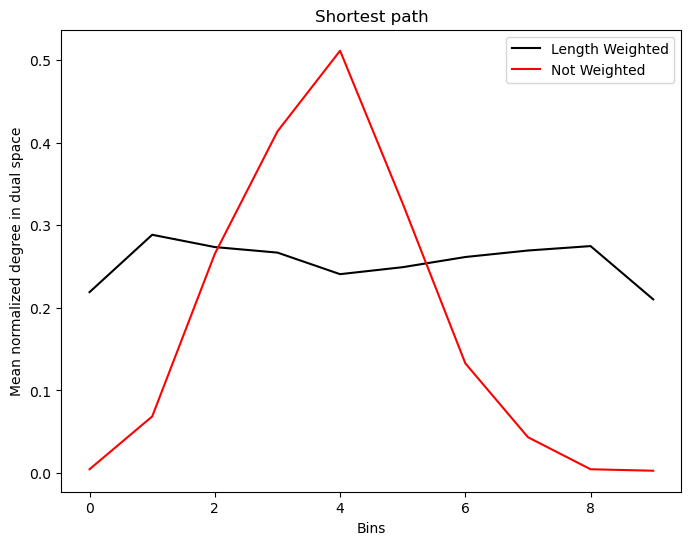

In [366]:
fig, ax = plt.subplots(figsize=(8,6),dpi=100)

n_bins = 10
xs_arr = np.concatenate(xs_w)
ys_arr = np.concatenate(ys_wn)
bins = np.linspace(0, 1, n_bins + 1)
idx = np.digitize(xs_arr, bins) - 1
bin_means = np.array([ys_arr[idx == i].mean() for i in range(n_bins)])
ax.plot(bin_means,label='Length Weighted',color='k')

xs_arr = np.concatenate(xs)
ys_arr = np.concatenate(ysn)
bins = np.linspace(0, 1, n_bins + 1)
idx = np.digitize(xs_arr, bins) - 1
bin_means = np.array([ys_arr[idx == i].mean() for i in range(n_bins)])
ax.plot(bin_means,label='Not Weighted',color='red')

plt.legend()
plt.ylabel('Mean normalized degree in dual space')
plt.xlabel('Bins')

plt.title('Shortest path')
plt.show()

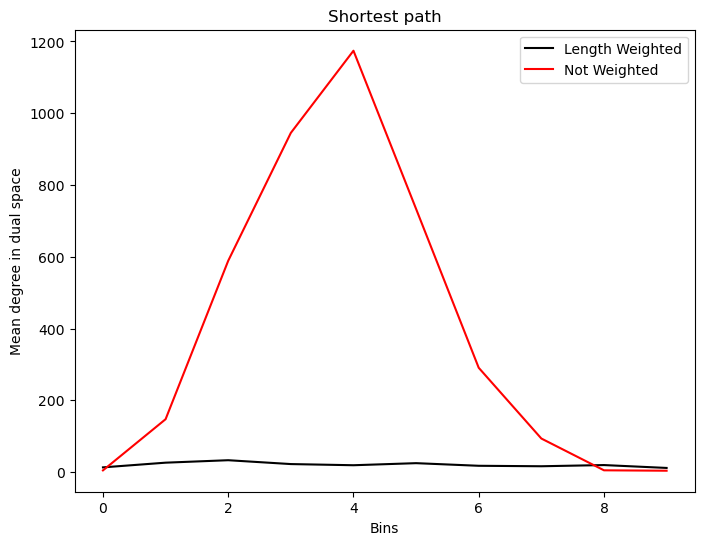

In [365]:
fig, ax = plt.subplots(figsize=(8,6),dpi=100)

n_bins = 10

xs_arr = np.concatenate(xs_w)
ys_arr = np.concatenate(ys_w)
bins = np.linspace(0, 1, n_bins + 1)
idx = np.digitize(xs_arr, bins) - 1
bin_means = np.array([ys_arr[idx == i].mean() for i in range(n_bins)])
ax.plot(bin_means,label='Length Weighted',color='k')

xs_arr = np.concatenate(xs)
ys_arr = np.concatenate(ys)
bins = np.linspace(0, 1, n_bins + 1)
idx = np.digitize(xs_arr, bins) - 1
bin_means = np.array([ys_arr[idx == i].mean() for i in range(n_bins)])
ax.plot(bin_means,label='Not Weighted',color='red')

plt.legend()
plt.ylabel('Mean degree in dual space')
plt.xlabel('Bins')

plt.title('Shortest path')
plt.show()